Interpolate the observations of _Calanus Finmarchicus_ and _Calanus Holandicus_.

The fields are prepared over a region covering the Northeast Atlantic.      
Different resolutions are tested: 0.5° X 0.5°, 1° X 1° and 2° X 2°.

In [18]:
using CSV
using Dates
using NCDatasets
using PyPlot
using DIVAnd
using Statistics
using PkgVersion
using PyPlot
const plt=PyPlot

PyPlot

In [2]:
ENV["PYTHON"]=""
using Pkg
Pkg.build("PyCall")
using PyCall
cmocean = PyCall.pyimport("cmocean")
colors = PyCall.pyimport("matplotlib.colors")

    Building Conda ─→ `~/.julia/scratchspaces/44cfe95a-1eb2-52ea-b672-e2afdf69b78f/6e47d11ea2776bc5627421d59cdcc1296c058071/build.log`
    Building PyCall → `~/.julia/scratchspaces/44cfe95a-1eb2-52ea-b672-e2afdf69b78f/53b8b07b721b77144a0fbbbc2675222ebf40a02d/build.log`
Precompiling project...
  ✓ ConfParser
  1 dependency successfully precompiled in 1 seconds. 93 already precompiled.


PyObject <module 'matplotlib.colors' from '/home/ctroupin/.julia/conda/3/lib/python3.7/site-packages/matplotlib/colors.py'>

## User settings
Set the domain of interest (west, east, south, north)

In [3]:
dom = [-20.5, 11.75, 41.25, 67.]
usecartopy = false

false

## Install `Cartopy`
Set `usecartopy` to `false` if you don't want to use it.

In [4]:
if usecartopy
    @info("Will try to use Cartopy for the plots")
    using Conda
    Conda.add("cartopy")
    cartopy = PyCall.pyimport("cartopy")
    ccrs = PyCall.pyimport("cartopy.crs")
    cfeature = PyCall.pyimport("cartopy.feature")
    mticker = PyCall.pyimport("matplotlib.ticker")
    coast = cfeature.GSHHSFeature(scale="full");
    cartopyticker = PyCall.pyimport("cartopy.mpl.ticker")
    lon_formatter = cartopyticker.LongitudeFormatter()
    lat_formatter = cartopyticker.LatitudeFormatter()
    mainproj = ccrs.Mercator(central_longitude=0.5*(dom[1] + dom[2]), min_latitude=dom[3], max_latitude=dom[4])
    datacrs = ccrs.PlateCarree();
end

## User inputs
### Type of analysis to be performed

In [5]:
run_year = false
run_month = true
makeplot = true

true

### Files and directories

In [6]:
datadir = "../data/"
figdir = "../figures/L05/"
resdir = "../results/L05/"
isdir(resdir) ? @debug("already there") : mkpath(resdir)
isdir(figdir) ? @debug("already there") : mkpath(figdir)
datafile = joinpath(datadir, "MBA_CPRdata_Emodnet_21Jan22.csv")
isfile(datafile) ? @debug("already downloaded") : download("https://dox.ulg.ac.be/index.php/s/hjWKf1F3C1Pzz1r/download", datafile)
bathfile = joinpath(datadir, "gebco_30sec_16.nc")
isfile(datafile), isfile(bathfile)

(true, true)

## Grid configuration

In [7]:
Δlon = 0.5
Δlat = 0.5
longrid = dom[1]:Δlon:dom[2]
latgrid = dom[3]:Δlat:dom[4]
@info("Size of the grid: $(length(longrid)) X $(length(latgrid))")

┌ Info: Size of the grid: 65 X 52
└ @ Main In[7]:5


### Metrics

In [8]:
_, (pm, pn), (xi, yi) = DIVAnd_rectdom(longrid, latgrid);
@info(size(xi));

┌ Info: (65, 52)
└ @ Main In[8]:2


### Prepare land-sea mask

In [9]:
bx, by, b = DIVAnd.load_bath(bathfile, true, longrid, latgrid)
@show size(b)

size(b) = (65, 52)


(65, 52)

In [10]:
_, _, mask = DIVAnd.load_mask(bathfile, true, longrid, latgrid, 0.0);
# Remove Mediterranean Sea

# - Resolution = 0.1°
# mask[220:end,1:60] .= 0;

# - Resolution = 0.5°
maskindex = findall((xi .>= 0.) .& (yi .<= 47.))
mask[maskindex] .= 0.;

sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


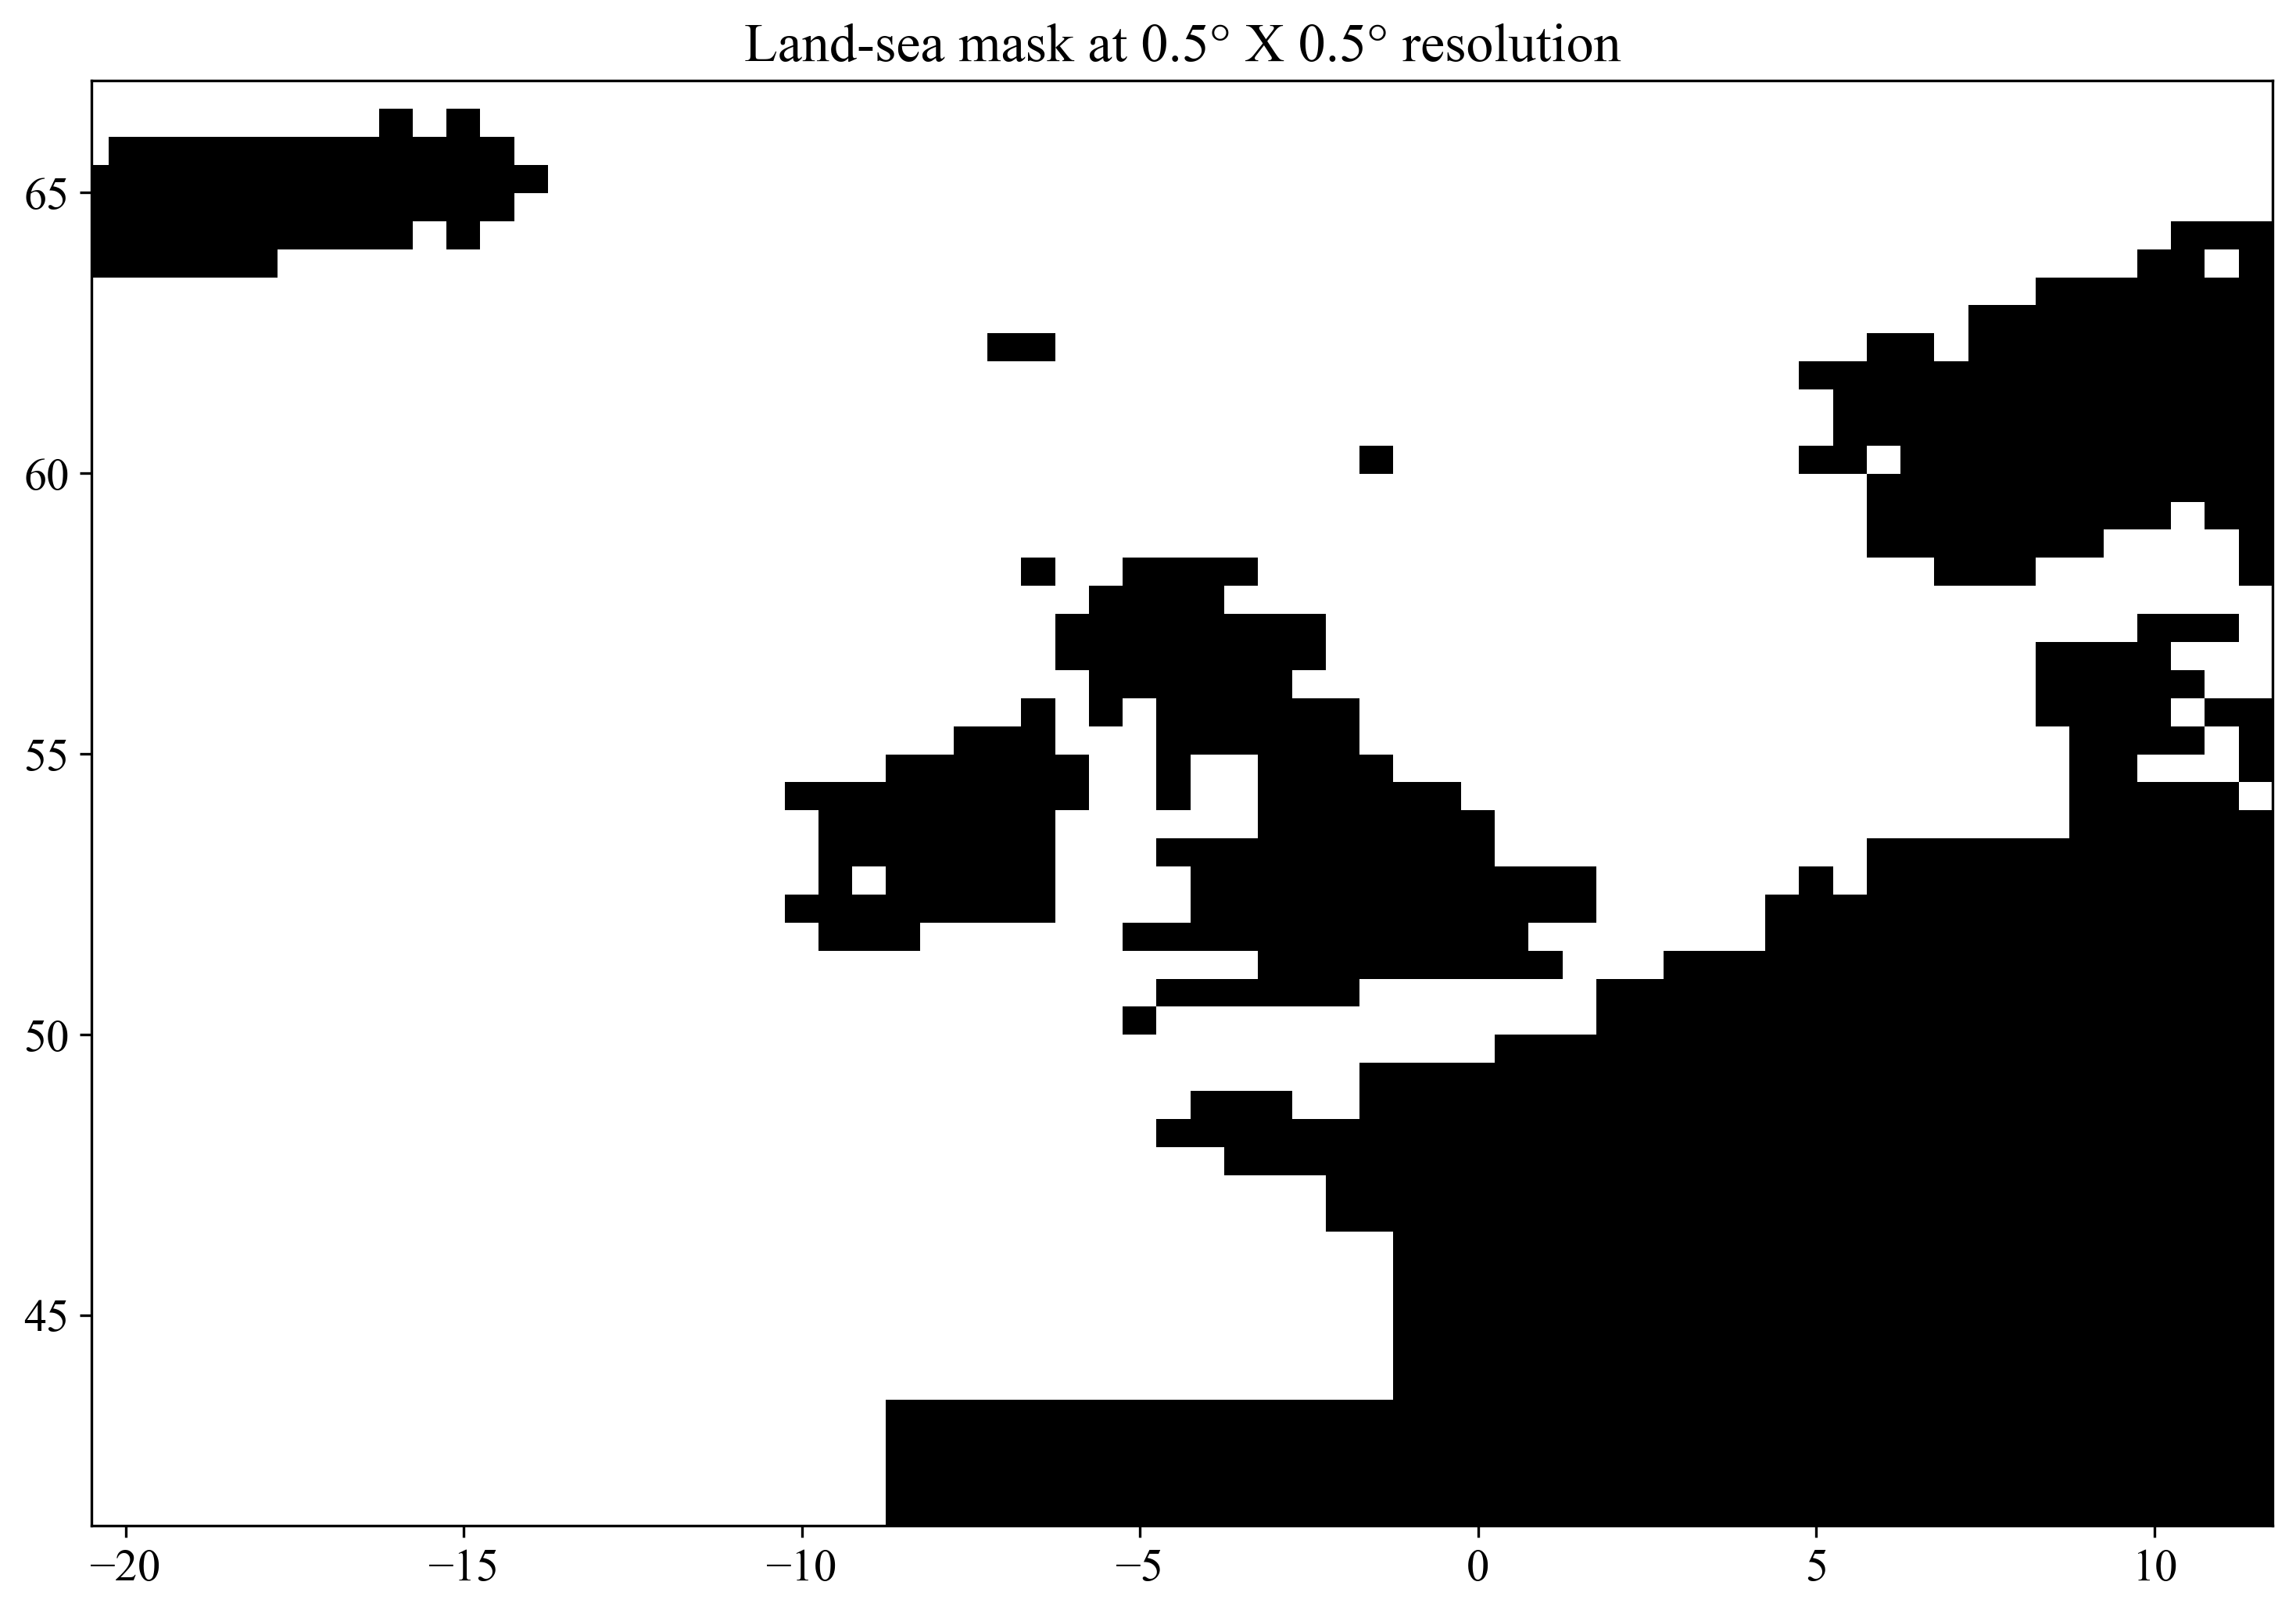

In [11]:
if makeplot
    fig = plt.figure(figsize=(12, 8))
    if usecartopy
        ax = plt.subplot(111, projection=mainproj)
        ax.set_extent(dom)
        ax.coastlines()
    else
        ax = plt.subplot(111)
        ax.set_xlim(dom[1], dom[2])
        ax.set_ylim(dom[3], dom[4])
    end 
    
    ax.pcolor(longrid, latgrid, mask', cmap=plt.cm.binary_r)
    ax.set_title("Land-sea mask at 0.5° X 0.5° resolution")
    plt.savefig(joinpath(figdir, "landseamask05.png"), dpi=300, bbox_inches="tight")
    plt.show()
end

## Data reading
### Read the CSV files and separate by columns

In [31]:
include("../src/InterpCalanus.jl")
@time lon, lat, dates, calanus_finmarchicus, calanus_helgolandicus = InterpCanalus.read_data_calanus(datafile);

  0.413662 seconds (4.53 M allocations: 143.376 MiB, 22.46% gc time)


┌ Info: (-20.447, 11.703)
└ @ Main.InterpCanalus /home/ctroupin/Projects/EMODnet/EMODnet-Bio-Interp-Calanus/src/InterpCalanus.jl:29
┌ Info: (41.2567, 66.808)
└ @ Main.InterpCanalus /home/ctroupin/Projects/EMODnet/EMODnet-Bio-Interp-Calanus/src/InterpCalanus.jl:30


## Analysis
### 1. Basic analysis: all data together

In [24]:
L = 2.5
epsilon2 = 5.

5.0

In [14]:
@time f_finmarchicus, s = DIVAndrun(mask, (pm,pn), (xi,yi), (lon, lat), 
    calanus_finmarchicus .- 0. * mean(calanus_finmarchicus), (L, L), epsilon2);
@time f_helgolandicus, s = DIVAndrun(mask, (pm,pn), (xi,yi), (lon, lat), 
    calanus_helgolandicus .- 0. * mean(calanus_helgolandicus), (L, L), epsilon2);

 21.674618 seconds (48.89 M allocations: 2.568 GiB, 6.87% gc time, 98.24% compilation time)
  0.338838 seconds (2.07 M allocations: 197.973 MiB, 7.04% gc time, 10.46% compilation time)


## Time analysis
### Yearly
#### Loop

In [34]:
run_year = true
if run_year 
    for yyyy in 1959:2018
        goodyear = findall(Dates.year.(dates) .== yyyy)
        @info("Number of observations for year $(yyyy): $(length(goodyear))")

        # Analysis
        @time f_finmarchicus, s_fin = DIVAndrun(mask, (pm,pn), (xi,yi), (lon[goodyear], lat[goodyear]), 
            calanus_finmarchicus[goodyear] .- 0. * mean(calanus_finmarchicus[goodyear]), (L, L), epsilon2);
        @time f_helgolandicus, s_hel = DIVAndrun(mask, (pm,pn), (xi,yi), (lon[goodyear], lat[goodyear]), 
            calanus_helgolandicus[goodyear] .- 0. * mean(calanus_helgolandicus[goodyear]), (L, L), epsilon2);
        
        # Error field
        cpme = DIVAnd_cpme(mask, (pm, pn), (xi, yi), (lon[goodyear], lat[goodyear]), 
            calanus_helgolandicus[goodyear], L, epsilon2);
        
        # Figures
        #figname = joinpath(figdir, "analysis_calanus_finmarchicus_$(yyyy).jpg")
        #make_plot_analysis(longrid, latgrid, f_finmarchicus .+ 0. * mean(calanus_finmarchicus[goodyear]), 
        #    "Calanus finmarchicus analysis ($(yyyy))", figname)

        #figname = joinpath(figdir, "analysis_calanus_helgolandicus_$(yyyy).jpg")
        #make_plot_analysis(longrid, latgrid, f_helgolandicus .+ 0. * mean(calanus_helgolandicus[goodyear]), 
        #    "Calanus helgolandicus analysis ($(yyyy))", figname)
        
        #figname = joinpath(figdir, "error_calanus_helgolandicus_$(yyyy).jpg")
        #make_plot_error(longrid, latgrid, cpme, lon[goodyear], lat[goodyear], 
        #    "Relative error field", figname)
        
        # netCDF files
        InterpCanalus.create_nc_results(joinpath(resdir, "finmarchicus_$(yyyy).nc"), 
                      longrid, latgrid, (Dates.Date(yyyy, 1, 1) - Dates.Date(1950, 1, 1)).value, 
                      f_finmarchicus .+ 0. * mean(calanus_finmarchicus[goodyear]), L, epsilon2,
                      "Calanus finmarchicus"; valex=-999.9, 
                      varname="abundance",
                      long_name="Abundance of Calanus finmarchicus",
                      domain=dom,
                      aphiaID=Int32(104464)
                   )
        
        InterpCanalus.write_nc_error(joinpath(resdir, "finmarchicus_$(yyyy).nc"), cpme)

        InterpCanalus.create_nc_results(joinpath(resdir, "helgolandicus_$(yyyy).nc"), 
                  longrid, latgrid, (Dates.Date(yyyy, 1, 1) - Dates.Date(1950, 1, 1)).value, 
                  f_helgolandicus .+ 0. * mean(calanus_helgolandicus[goodyear]), L, epsilon2, 
                  "Calanus helgolandicus"; valex=-999.9, 
                  varname="abundance",
                  long_name="Abundance of Calanus helgolandicus",
                  domain=dom,
                  aphiaID=Int32(104466)
               )
        
        InterpCanalus.write_nc_error(joinpath(resdir, "helgolandicus_$(yyyy).nc"), cpme)

    end
end

  0.017465 seconds (35.36 k allocations: 32.357 MiB)
  0.022338 seconds (35.37 k allocations: 32.358 MiB, 16.95% gc time)
  0.017950 seconds (34.76 k allocations: 32.301 MiB)


┌ Info: Number of observations for year 1959: 2364
└ @ Main In[34]:5
┌ Info: Number of observations for year 1960: 2321
└ @ Main In[34]:5


  0.022008 seconds (34.77 k allocations: 32.301 MiB, 15.23% gc time)
  0.019603 seconds (35.62 k allocations: 32.372 MiB)
  0.023037 seconds (35.63 k allocations: 32.372 MiB, 15.06% gc time)


┌ Info: Number of observations for year 1961: 2382
└ @ Main In[34]:5


  0.021252 seconds (38.17 k allocations: 32.580 MiB)
  0.029069 seconds (38.18 k allocations: 32.581 MiB, 16.42% gc time)


┌ Info: Number of observations for year 1962: 2564
└ @ Main In[34]:5
┌ Info: Number of observations for year 1963: 2465
└ @ Main In[34]:5


  0.019515 seconds (36.77 k allocations: 32.467 MiB)
  0.030290 seconds (36.78 k allocations: 32.468 MiB, 13.18% gc time)
  0.025069 seconds (38.06 k allocations: 32.584 MiB, 13.07% gc time)


┌ Info: Number of observations for year 1964: 2556
└ @ Main In[34]:5


  0.019915 seconds (38.05 k allocations: 32.584 MiB)
  0.024585 seconds (41.17 k allocations: 32.842 MiB, 13.71% gc time)
  0.019978 seconds (41.16 k allocations: 32.842 MiB)


┌ Info: Number of observations for year 1965: 2777
└ @ Main In[34]:5


  0.032072 seconds (36.19 k allocations: 32.411 MiB, 11.01% gc time)
  0.026018 seconds (36.18 k allocations: 32.411 MiB)


┌ Info: Number of observations for year 1966: 2422
└ @ Main In[34]:5
┌ Info: Number of observations for year 1967: 2679
└ @ Main In[34]:5


  0.025134 seconds (39.79 k allocations: 32.719 MiB, 13.32% gc time)
  0.022323 seconds (39.78 k allocations: 32.719 MiB)
  0.024452 seconds (37.14 k allocations: 32.506 MiB, 15.12% gc time)


┌ Info: Number of observations for year 1968: 2489
└ @ Main In[34]:5


  0.020554 seconds (37.13 k allocations: 32.505 MiB)
  0.024930 seconds (42.37 k allocations: 32.955 MiB, 13.95% gc time)
  0.020961 seconds (42.36 k allocations: 32.955 MiB)


┌ Info: Number of observations for year 1969: 2863
└ @ Main In[34]:5


  0.028155 seconds (40.10 k allocations: 32.768 MiB, 13.34% gc time)
  0.022785 seconds (40.09 k allocations: 32.768 MiB)


┌ Info: Number of observations for year 1970: 2701
└ @ Main In[34]:5
┌ Info: Number of observations for year 1971: 2964
└ @ Main In[34]:5


  0.026701 seconds (43.78 k allocations: 33.036 MiB, 14.31% gc time)
  0.024946 seconds (43.77 k allocations: 33.036 MiB)


┌ Info: Number of observations for year 1972: 2808
└ @ Main In[34]:5


  0.026267 seconds (41.63 k allocations: 32.840 MiB, 13.82% gc time)
  0.024366 seconds (41.61 k allocations: 32.839 MiB)
  0.024149 seconds (41.34 k allocations: 32.824 MiB, 14.39% gc time)


┌ Info: Number of observations for year 1973: 2788
└ @ Main In[34]:5


  0.019415 seconds (41.33 k allocations: 32.824 MiB)
  0.026431 seconds (38.70 k allocations: 32.615 MiB, 15.69% gc time)
  0.019084 seconds (38.69 k allocations: 32.615 MiB)


┌ Info: Number of observations for year 1974: 2600
└ @ Main In[34]:5


  0.025314 seconds (37.14 k allocations: 32.471 MiB)
  0.022400 seconds (37.14 k allocations: 32.471 MiB)


┌ Info: Number of observations for year 1975: 2490
└ @ Main In[34]:5
┌ Info: Number of observations for year 1976: 2361
└ @ Main In[34]:5


  0.018744 seconds (35.32 k allocations: 32.305 MiB)
  0.022951 seconds (35.33 k allocations: 32.305 MiB)
  0.019153 seconds (34.17 k allocations: 32.189 MiB)


┌ Info: Number of observations for year 1977: 2267
└ @ Main In[34]:5


  0.018197 seconds (34.17 k allocations: 32.189 MiB)
  0.038829 seconds (28.16 k allocations: 31.606 MiB, 14.94% gc time)


┌ Info: Number of observations for year 1978: 1841
└ @ Main In[34]:5


  0.029817 seconds (28.15 k allocations: 31.606 MiB)
  0.036623 seconds (29.28 k allocations: 31.703 MiB, 11.98% gc time)


┌ Info: Number of observations for year 1979: 1925
└ @ Main In[34]:5


  0.037053 seconds (29.26 k allocations: 31.703 MiB)
  0.033001 seconds (31.09 k allocations: 31.983 MiB, 13.69% gc time)


┌ Info: Number of observations for year 1980: 2047
└ @ Main In[34]:5


  0.031004 seconds (31.08 k allocations: 31.983 MiB)
  0.022993 seconds (32.44 k allocations: 32.077 MiB, 14.82% gc time)
  0.022288 seconds (32.42 k allocations: 32.077 MiB)


┌ Info: Number of observations for year 1981: 2141
└ @ Main In[34]:5


  0.038199 seconds (32.98 k allocations: 32.133 MiB, 12.72% gc time)
  0.031033 seconds (32.96 k allocations: 32.133 MiB)


┌ Info: Number of observations for year 1982: 2192
└ @ Main In[34]:5


  0.029041 seconds (37.33 k allocations: 32.499 MiB)
  0.033166 seconds (37.35 k allocations: 32.499 MiB, 15.39% gc time)


┌ Info: Number of observations for year 1983: 2505
└ @ Main In[34]:5


  0.026666 seconds (33.34 k allocations: 32.165 MiB)
  0.030794 seconds (33.35 k allocations: 32.165 MiB, 15.81% gc time)


┌ Info: Number of observations for year 1984: 2219
└ @ Main In[34]:5


  0.023018 seconds (37.02 k allocations: 32.475 MiB)
  0.026772 seconds (37.03 k allocations: 32.475 MiB, 13.28% gc time)


┌ Info: Number of observations for year 1985: 2482
└ @ Main In[34]:5
┌ Info: Number of observations for year 1986: 2493
└ @ Main In[34]:5


  0.026191 seconds (37.19 k allocations: 32.479 MiB)
  0.038427 seconds (37.20 k allocations: 32.479 MiB, 11.14% gc time)
  0.026472 seconds (31.00 k allocations: 31.933 MiB)
  0.039495 seconds (31.02 k allocations: 31.933 MiB, 16.63% gc time)


┌ Info: Number of observations for year 1987: 2052
└ @ Main In[34]:5


  0.031142 seconds (31.77 k allocations: 32.013 MiB)


┌ Info: Number of observations for year 1988: 2107
└ @ Main In[34]:5


  0.072038 seconds (31.79 k allocations: 32.014 MiB, 50.48% gc time)


┌ Info: Number of observations for year 1989: 1999
└ @ Main In[34]:5


  0.032391 seconds (30.24 k allocations: 31.744 MiB)
  0.026154 seconds (30.25 k allocations: 31.744 MiB)


┌ Info: Number of observations for year 1990: 1989
└ @ Main In[34]:5


  0.030802 seconds (30.10 k allocations: 31.735 MiB)
  0.021679 seconds (30.10 k allocations: 31.735 MiB)


┌ Info: Number of observations for year 1991: 2184
└ @ Main In[34]:5


  0.032380 seconds (32.87 k allocations: 32.097 MiB)
  0.035124 seconds (32.87 k allocations: 32.097 MiB)
  0.030229 seconds (31.55 k allocations: 31.994 MiB)
  0.031259 seconds (31.56 k allocations: 31.994 MiB)


┌ Info: Number of observations for year 1992: 2087
└ @ Main In[34]:5


  0.023905 seconds (36.99 k allocations: 32.440 MiB)
  0.022168 seconds (36.99 k allocations: 32.440 MiB)


┌ Info: Number of observations for year 1993: 2479
└ @ Main In[34]:5


  0.021095 seconds (37.77 k allocations: 32.513 MiB)
  0.025136 seconds (37.77 k allocations: 32.513 MiB)


┌ Info: Number of observations for year 1994: 2535
└ @ Main In[34]:5
┌ Info: Number of observations for year 1995: 2435
└ @ Main In[34]:5


  0.029298 seconds (36.37 k allocations: 32.390 MiB, 15.34% gc time)
  0.025814 seconds (36.35 k allocations: 32.390 MiB)


┌ Info: Number of observations for year 1996: 1890
└ @ Main In[34]:5


  0.039091 seconds (28.72 k allocations: 31.640 MiB, 10.64% gc time)
  0.031640 seconds (28.70 k allocations: 31.639 MiB)


┌ Info: Number of observations for year 1997: 2513
└ @ Main In[34]:5


  0.028509 seconds (37.48 k allocations: 32.514 MiB, 12.89% gc time)
  0.024773 seconds (37.47 k allocations: 32.514 MiB)


┌ Info: Number of observations for year 1998: 2299
└ @ Main In[34]:5


  0.041416 seconds (34.49 k allocations: 32.271 MiB, 10.74% gc time)
  0.048456 seconds (34.48 k allocations: 32.271 MiB)
  0.034393 seconds (36.23 k allocations: 32.405 MiB, 10.68% gc time)
  0.026216 seconds (36.22 k allocations: 32.405 MiB)


┌ Info: Number of observations for year 1999: 2424
└ @ Main In[34]:5


  0.029718 seconds (34.70 k allocations: 32.277 MiB, 15.01% gc time)
  0.024814 seconds (34.69 k allocations: 32.276 MiB)


┌ Info: Number of observations for year 2000: 2315
└ @ Main In[34]:5
┌ Info: Number of observations for year 2001: 2536
└ @ Main In[34]:5


  0.024511 seconds (37.78 k allocations: 32.529 MiB)
  0.025479 seconds (37.80 k allocations: 32.529 MiB, 15.00% gc time)
  0.018540 seconds (39.78 k allocations: 32.713 MiB)


┌ Info: Number of observations for year 2002: 2680
└ @ Main In[34]:5


  0.023251 seconds (39.79 k allocations: 32.713 MiB, 14.52% gc time)
  0.017617 seconds (36.05 k allocations: 32.400 MiB)
  0.022542 seconds (36.06 k allocations: 32.401 MiB, 14.69% gc time)


┌ Info: Number of observations for year 2003: 2414
└ @ Main In[34]:5


  0.019309 seconds (38.64 k allocations: 32.609 MiB)
  0.023378 seconds (38.65 k allocations: 32.610 MiB, 15.19% gc time)


┌ Info: Number of observations for year 2004: 2598
└ @ Main In[34]:5
┌ Info: Number of observations for year 2005: 2771
└ @ Main In[34]:5


  0.019310 seconds (41.05 k allocations: 32.797 MiB)
  0.024726 seconds (41.06 k allocations: 32.798 MiB, 14.20% gc time)
  0.017754 seconds (39.69 k allocations: 32.685 MiB)


┌ Info: Number of observations for year 2006: 2674
└ @ Main In[34]:5


  0.023170 seconds (39.70 k allocations: 32.685 MiB, 14.28% gc time)
  0.020678 seconds (34.89 k allocations: 32.285 MiB)
  0.024398 seconds (34.90 k allocations: 32.285 MiB, 16.09% gc time)


┌ Info: Number of observations for year 2007: 2331
└ @ Main In[34]:5


  0.033678 seconds (37.90 k allocations: 32.529 MiB)
  0.054136 seconds (37.90 k allocations: 32.529 MiB)


┌ Info: Number of observations for year 2008: 2544
└ @ Main In[34]:5


  0.033961 seconds (37.48 k allocations: 32.512 MiB)
  0.031197 seconds (37.48 k allocations: 32.512 MiB)


┌ Info: Number of observations for year 2009: 2515
└ @ Main In[34]:5


  0.039068 seconds (40.98 k allocations: 32.804 MiB)
  0.040035 seconds (40.98 k allocations: 32.804 MiB)


┌ Info: Number of observations for year 2010: 2764
└ @ Main In[34]:5


  0.025645 seconds (40.74 k allocations: 32.796 MiB)
  0.024645 seconds (40.74 k allocations: 32.796 MiB)


┌ Info: Number of observations for year 2011: 2747
└ @ Main In[34]:5


  0.030387 seconds (37.51 k allocations: 32.519 MiB)
  0.025896 seconds (37.51 k allocations: 32.519 MiB)


┌ Info: Number of observations for year 2012: 2517
└ @ Main In[34]:5


  0.028309 seconds (41.85 k allocations: 32.878 MiB)
  0.024065 seconds (41.84 k allocations: 32.878 MiB)


┌ Info: Number of observations for year 2013: 2827
└ @ Main In[34]:5


  0.022875 seconds (41.46 k allocations: 32.859 MiB)
  0.022712 seconds (41.46 k allocations: 32.859 MiB)


┌ Info: Number of observations for year 2014: 2798
└ @ Main In[34]:5
┌ Info: Number of observations for year 2015: 2486
└ @ Main In[34]:5


  0.023327 seconds (37.09 k allocations: 32.465 MiB, 15.11% gc time)
  0.019709 seconds (37.07 k allocations: 32.465 MiB)
  0.023235 seconds (40.01 k allocations: 32.725 MiB, 14.87% gc time)
  0.018599 seconds (39.99 k allocations: 32.724 MiB)


┌ Info: Number of observations for year 2016: 2695
└ @ Main In[34]:5


  0.024292 seconds (30.84 k allocations: 31.801 MiB, 14.26% gc time)
  0.018554 seconds (30.83 k allocations: 31.801 MiB)
  0.021965 seconds (33.17 k allocations: 32.129 MiB, 14.98% gc time)


┌ Info: Number of observations for year 2017: 2041
└ @ Main In[34]:5
┌ Info: Number of observations for year 2018: 2206
└ @ Main In[34]:5


  0.018265 seconds (33.16 k allocations: 32.129 MiB)


### Monthly

In [19]:
"""
    create_nc_results_time(filename, lons, lats)

Create a new netCDF file `filename` with the coordinates `lons`, `lats` that will 
be filled with interpolated field and error field.

## Examples
```julia-repl
julia> create_nc_results_time("Bacteriastrum_interp.nc", lons, lats)
```
"""
function create_nc_results_time(filename::String, lons, lats, speciesname="";
                           valex=-999.9,
                           varname::String = "abundance",
                           long_name::String = "Interpolated abundance",
						   domain::Array = [-180., 180., -90., 90.],
						   aphiaID::Int32 = 0
                           )
    Dataset(filename, "c") do ds

        # Dimensions
        ds.dim["lon"] = length(lons)
        ds.dim["lat"] = length(lats)
        ds.dim["time"] = Inf # unlimited dimension

        # Declare variables
		nccrs = defVar(ds, "crs", Int64, ())
    	nccrs.attrib["grid_mapping_name"] = "latitude_longitude"
    	nccrs.attrib["semi_major_axis"] = 6371000.0 ;
    	nccrs.attrib["inverse_flattening"] = 0 ;

        ncfield = defVar(ds, varname, Float64, ("lon", "lat", "time"))
        ncfield.attrib["missing_value"] = Float64(valex)
        ncfield.attrib["_FillValue"] = Float64(valex)
		ncfield.attrib["units"] = "1"
        ncfield.attrib["long_name"] = long_name
		ncfield.attrib["coordinates"] = "lat lon time"
		ncfield.attrib["grid_mapping"] = "crs" ;
        
        ncerror = defVar(ds, "error", Float64, ("lon", "lat", "time"))
        ncerror.attrib["missing_value"] = Float64(valex)
        ncerror.attrib["_FillValue"] = Float64(valex)
		ncerror.attrib["units"] = "1"
        ncerror.attrib["long_name"] = "Relative error on $(long_name)"
		ncerror.attrib["coordinates"] = "lat lon time"
		ncerror.attrib["grid_mapping"] = "crs" ;
        
        nclon = defVar(ds,"lon", Float32, ("lon",))
        # nclon.attrib["missing_value"] = Float32(valex)
        nclon.attrib["_FillValue"] = Float32(valex)
        nclon.attrib["units"] = "degrees_east"
        nclon.attrib["long_name"] = "Longitude"
		nclon.attrib["standard_name"] = "longitude"
		nclon.attrib["axis"] = "X"
		nclon.attrib["reference_datum"] = "geographical coordinates, WGS84 projection"
		nclon.attrib["valid_min"] = -180.0 ;
		nclon.attrib["valid_max"] = 180.0 ;

        nclat = defVar(ds,"lat", Float32, ("lat",))
        # nclat.attrib["missing_value"] = Float32(valex)
        nclat.attrib["_FillValue"] = Float32(valex)
        nclat.attrib["units"] = "degrees_north"
		nclat.attrib["long_name"] = "Latitude"
		nclat.attrib["standard_name"] = "latitude"
		nclat.attrib["axis"] = "Y"
		nclat.attrib["reference_datum"] = "geographical coordinates, WGS84 projection"
		nclat.attrib["valid_min"] = -90.0 ;
		nclat.attrib["valid_max"] = 90.0 ;
        
        nctime = defVar(ds,"time", Float32, ("time",))
        #nctime.attrib["_FillValue"] = Float32(valex)
        nctime.attrib["units"] = "degrees_north"
		nctime.attrib["long_name"] = "Time"
		nctime.attrib["standard_name"] = "time"
        nctime.attrib["units"] = "days since 1950-01-01 00:00:00"
		nctime.attrib["axis"] = "T"

        # Global attributes
		ds.attrib["Species_scientific_name"] = speciesname
		ds.attrib["Species_aphiaID"] = aphiaID
		ds.attrib["title"] = "$(long_name) based on presence/absence of $(speciesname)"
		ds.attrib["institution"] = "GHER - University of Liege, MBA"
		ds.attrib["source"] = "Spatial interpolation of presence/absence data"
        ds.attrib["project"] = "EMODnet Biology Phase IV"
        ds.attrib["comment"] = "Original data prepared by P. Helaouet"
        ds.attrib["data_authors"] = "Pierre Helaouet <pihe@MBA.ac.uk>"
        ds.attrib["processing_authors"] = "C. Troupin <ctroupin@uliege>, A. Barth <a.barth@uliege.be>"
		ds.attrib["publisher_name"] = "VLIZ"
		ds.attrib["publisher_url"] = "http://www.vliz.be/"
		ds.attrib["publisher_email"] = "info@vliz.be"
        ds.attrib["created"] = Dates.format(Dates.now(), "yyyy-mm-dd HH:MM:SS")
		ds.attrib["geospatial_lat_min"] = domain[3]
		ds.attrib["geospatial_lat_max"] = domain[4]
		ds.attrib["geospatial_lon_min"] = domain[1]
		ds.attrib["geospatial_lon_max"] = domain[2]
		ds.attrib["geospatial_lat_units"] = "degrees_north"
		ds.attrib["geospatial_lon_units"] = "degrees_east"
		ds.attrib["license"] = "GNU General Public License v2.0"
		ds.attrib["citation"] = "to be filled"
		ds.attrib["acknowledgement"] = "to be filled"
		ds.attrib["tool"] = "DIVAnd"
		ds.attrib["tool_version"] = "2.7.6"
		ds.attrib["tool_doi"] = "10.5281/zenodo.4306494"
		ds.attrib["language"] = "Julia 1.7.0"
		ds.attrib["Conventions"] = "CF-1.7"
		ds.attrib["netcdf_version"] = "4"
        ds.attrib["Correlation length (degrees)"] = L
        ds.attrib["Noise-to-signal ratio"] = epsilon2

        # Define variables
        nclon[:] = collect(lons)
        nclat[:] = collect(lats);

    end
end;

In [20]:
resfile1 = joinpath(resdir, "calanus_finmarchicus_year_month.nc")
resfile2 = joinpath(resdir, "calanus_helgolandicus_year_month.nc")


create_nc_results_time(resfile1, longrid, latgrid,  
                      "Calanus finmarchicus"; valex=-999.9, 
                      varname="abundance",
                      long_name="Abundance of Calanus finmarchicus",
                      domain=dom,
                      aphiaID=Int32(104464));

create_nc_results_time(resfile2, longrid, latgrid,  
                      "Calanus helgolandicus"; valex=-999.9, 
                      varname="abundance",
                      long_name="Abundance of Calanus helgolandicus",
                      domain=dom,
                      aphiaID=Int32(104466));

In [21]:
iii = 0
for yyyy in 1959:2018

    for m in 1:12
        
        iii += 1

        mm = lpad(string(m), 2, '0')
        goodtime = findall( (year .== yyyy) .& (month .== m) )
        @info("Found $(length(goodtime)) dates points for year $(yyyy) | month $(mm)")
        
        if length(goodtime) > 0

            @time f_finmarchicus, s = DIVAndrun(mask, (pm,pn), (xi,yi), (lon[goodtime], lat[goodtime]), 
                calanus_finmarchicus[goodtime] .- mean(calanus_finmarchicus[goodtime]), (L, L), epsilon2);
            @time f_helgolandicus, s = DIVAndrun(mask, (pm,pn), (xi,yi), (lon[goodtime], lat[goodtime]), 
                calanus_helgolandicus[goodtime] .- mean(calanus_helgolandicus[goodtime]), (L, L), epsilon2);
            
            # Error field
            cpme_fin = DIVAnd_cpme(mask, (pm, pn), (xi, yi), (lon[goodtime], lat[goodtime]), 
                calanus_finmarchicus[goodtime], L, epsilon2);
            cpme_hel = DIVAnd_cpme(mask, (pm, pn), (xi, yi), (lon[goodtime], lat[goodtime]), 
                calanus_helgolandicus[goodtime], L, epsilon2);
            

            figname = joinpath(figdir, "analysis_calanus_finmarchicus_$(yyyy)$(mm).jpg")
            #make_plot_analysis(longrid, latgrid, f_finmarchicus .+ mean(calanus_finmarchicus[goodtime]), 
            #    "Calanus finmarchicus analysis ($(Dates.monthname(m)) $(yyyy))", figname)

            figname = joinpath(figdir, "analysis_calanus_helgolandicus_$(yyyy)$(mm).jpg")
            #make_plot_analysis(longrid, latgrid, f_helgolandicus .+ mean(calanus_helgolandicus[goodtime]), 
            #    "Calanus finmarchicus analysis ($(Dates.monthname(m)) $(yyyy))", figname)

         
            Dataset(resfile1, "a") do ds
                ds["time"][iii] = (Dates.Date(yyyy, m, 1) - Dates.Date(1950, 1, 1)).value
                ds["error"][:,:,iii] = cpme_fin
                ds["abundance"][:,:,iii] = f_finmarchicus
            end
            
            Dataset(resfile2, "a") do ds
                ds["time"][iii] = (Dates.Date(yyyy, m, 1) - Dates.Date(1950, 1, 1)).value
                ds["error"][:,:,iii] = cpme_hel
                ds["abundance"][:,:,iii] = f_helgolandicus
            end
            
        else
            @warn("No data to perform analysis")
        end

    end

end

  0.172127 seconds (4.71 k allocations: 118.531 MiB, 4.40% gc time)
  0.236978 seconds (4.71 k allocations: 118.531 MiB, 2.85% gc time)
  0.150832 seconds (4.75 k allocations: 118.535 MiB, 4.82% gc time)
  0.181178 seconds (4.75 k allocations: 118.535 MiB, 3.63% gc time)
  0.164147 seconds (6.09 k allocations: 118.682 MiB)
  0.195356 seconds (6.10 k allocations: 118.683 MiB, 2.76% gc time)
  0.164610 seconds (4.49 k allocations: 118.499 MiB, 2.20% gc time)
  0.208539 seconds (4.49 k allocations: 118.499 MiB)
  0.160840 seconds (5.50 k allocations: 118.620 MiB)
  0.188646 seconds (5.51 k allocations: 118.620 MiB, 3.27% gc time)
  0.164253 seconds (5.84 k allocations: 118.658 MiB, 2.40% gc time)
  0.183162 seconds (5.83 k allocations: 118.658 MiB)
  0.153352 seconds (5.69 k allocations: 118.637 MiB)
  0.348805 seconds (5.70 k allocations: 118.638 MiB, 57.04% gc time)
  0.156915 seconds (5.74 k allocations: 118.648 MiB, 5.45% gc time)
  0.199297 seconds (5.74 k allocations: 118.648 MiB, 1

┌ Info: Found 141 dates points for year 1959 | month 01
└ @ Main In[21]:10
┌ Info: Found 144 dates points for year 1959 | month 02
└ @ Main In[21]:10
┌ Info: Found 247 dates points for year 1959 | month 03
└ @ Main In[21]:10
┌ Info: Found 124 dates points for year 1959 | month 04
└ @ Main In[21]:10
┌ Info: Found 202 dates points for year 1959 | month 05
└ @ Main In[21]:10
┌ Info: Found 227 dates points for year 1959 | month 06
└ @ Main In[21]:10
┌ Info: Found 216 dates points for year 1959 | month 07
└ @ Main In[21]:10
┌ Info: Found 220 dates points for year 1959 | month 08
└ @ Main In[21]:10
┌ Info: Found 239 dates points for year 1959 | month 09
└ @ Main In[21]:10
┌ Info: Found 270 dates points for year 1959 | month 10
└ @ Main In[21]:10
┌ Info: Found 183 dates points for year 1959 | month 11
└ @ Main In[21]:10
┌ Info: Found 151 dates points for year 1959 | month 12
└ @ Main In[21]:10
┌ Info: Found 160 dates points for year 1960 | month 01
└ @ Main In[21]:10
┌ Info: Found 186 dates p

  0.208556 seconds (6.79 k allocations: 118.815 MiB, 1.39% gc time)
  0.250167 seconds (6.60 k allocations: 118.794 MiB, 2.29% gc time)
  0.250499 seconds (6.60 k allocations: 118.794 MiB, 1.45% gc time)
  0.333984 seconds (6.53 k allocations: 118.787 MiB, 1.62% gc time)
  0.344306 seconds (6.52 k allocations: 118.786 MiB, 1.22% gc time)
  0.294083 seconds (5.89 k allocations: 118.663 MiB, 1.56% gc time)
  0.291924 seconds (5.88 k allocations: 118.663 MiB)
  0.245872 seconds (4.89 k allocations: 118.552 MiB)
  0.311886 seconds (4.90 k allocations: 118.552 MiB, 24.84% gc time)
  0.485878 seconds (5.08 k allocations: 118.572 MiB, 43.71% gc time)
  0.217743 seconds (5.08 k allocations: 118.572 MiB)
  0.156925 seconds (6.04 k allocations: 118.679 MiB, 2.98% gc time)
  0.165540 seconds (6.04 k allocations: 118.679 MiB, 2.08% gc time)
  0.136911 seconds (4.95 k allocations: 118.558 MiB, 2.53% gc time)
  0.172854 seconds (4.95 k allocations: 118.558 MiB, 1.21% gc time)
  0.184180 seconds (5.7

  0.182677 seconds (5.90 k allocations: 118.663 MiB, 2.20% gc time)
  0.212692 seconds (5.90 k allocations: 118.663 MiB)
  0.197880 seconds (5.83 k allocations: 118.653 MiB, 3.96% gc time)
  0.293721 seconds (5.82 k allocations: 118.653 MiB, 18.57% gc time)
  0.168628 seconds (5.54 k allocations: 118.620 MiB)
  0.353144 seconds (5.55 k allocations: 118.620 MiB, 53.89% gc time)
  0.176259 seconds (6.23 k allocations: 118.753 MiB, 6.95% gc time)
  0.203165 seconds (6.23 k allocations: 118.753 MiB, 1.85% gc time)
  0.167005 seconds (6.16 k allocations: 118.691 MiB, 2.94% gc time)
  0.405214 seconds (6.16 k allocations: 118.691 MiB, 0.69% gc time)
  0.148760 seconds (5.90 k allocations: 118.665 MiB)
  0.264998 seconds (5.90 k allocations: 118.665 MiB, 1.34% gc time)
  0.149846 seconds (5.31 k allocations: 118.597 MiB, 2.39% gc time)
  0.139727 seconds (5.31 k allocations: 118.597 MiB)
  0.181522 seconds (6.34 k allocations: 118.758 MiB, 2.12% gc time)
  0.209201 seconds (6.33 k allocations

┌ Info: Found 287 dates points for year 1969 | month 11
└ @ Main In[21]:10
┌ Info: Found 147 dates points for year 1969 | month 12
└ @ Main In[21]:10
┌ Info: Found 173 dates points for year 1970 | month 01
└ @ Main In[21]:10
┌ Info: Found 189 dates points for year 1970 | month 02
└ @ Main In[21]:10
┌ Info: Found 186 dates points for year 1970 | month 03
└ @ Main In[21]:10
┌ Info: Found 312 dates points for year 1970 | month 04
└ @ Main In[21]:10
┌ Info: Found 245 dates points for year 1970 | month 05
└ @ Main In[21]:10
┌ Info: Found 257 dates points for year 1970 | month 06
└ @ Main In[21]:10
┌ Info: Found 202 dates points for year 1970 | month 07
└ @ Main In[21]:10
┌ Info: Found 272 dates points for year 1970 | month 08
└ @ Main In[21]:10
┌ Info: Found 250 dates points for year 1970 | month 09
└ @ Main In[21]:10
┌ Info: Found 147 dates points for year 1970 | month 10
└ @ Main In[21]:10
┌ Info: Found 217 dates points for year 1970 | month 11
└ @ Main In[21]:10
┌ Info: Found 251 dates p

  0.284358 seconds (5.66 k allocations: 118.638 MiB, 15.81% gc time)
  0.135768 seconds (5.17 k allocations: 118.582 MiB)
  0.437933 seconds (5.18 k allocations: 118.582 MiB, 39.48% gc time)
  0.265083 seconds (4.37 k allocations: 118.482 MiB, 1.38% gc time)
  0.296199 seconds (4.37 k allocations: 118.482 MiB, 1.07% gc time)
  0.286329 seconds (4.90 k allocations: 118.552 MiB, 2.50% gc time)
  0.361752 seconds (4.89 k allocations: 118.552 MiB, 0.90% gc time)
  0.131197 seconds (5.01 k allocations: 118.565 MiB, 3.56% gc time)
  0.179720 seconds (5.01 k allocations: 118.565 MiB, 1.84% gc time)
  0.296350 seconds (5.24 k allocations: 118.587 MiB)
  0.200373 seconds (5.25 k allocations: 118.587 MiB, 3.29% gc time)
  0.134161 seconds (4.75 k allocations: 118.535 MiB)
  0.179371 seconds (4.76 k allocations: 118.535 MiB, 3.60% gc time)
  0.147180 seconds (4.99 k allocations: 118.561 MiB, 4.52% gc time)
  0.178502 seconds (4.99 k allocations: 118.561 MiB, 2.01% gc time)
  0.253324 seconds (5.1

┌ Info: Found 230 dates points for year 1980 | month 09
└ @ Main In[21]:10
┌ Info: Found 234 dates points for year 1980 | month 10
└ @ Main In[21]:10
┌ Info: Found 192 dates points for year 1980 | month 11
└ @ Main In[21]:10
┌ Info: Found 144 dates points for year 1980 | month 12
└ @ Main In[21]:10
┌ Info: Found 112 dates points for year 1981 | month 01
└ @ Main In[21]:10
┌ Info: Found 168 dates points for year 1981 | month 02
└ @ Main In[21]:10
┌ Info: Found 251 dates points for year 1981 | month 03
└ @ Main In[21]:10
┌ Info: Found 206 dates points for year 1981 | month 04
└ @ Main In[21]:10
┌ Info: Found 179 dates points for year 1981 | month 05
└ @ Main In[21]:10
┌ Info: Found 211 dates points for year 1981 | month 06
└ @ Main In[21]:10
┌ Info: Found 194 dates points for year 1981 | month 07
└ @ Main In[21]:10
┌ Info: Found 99 dates points for year 1981 | month 08
└ @ Main In[21]:10
┌ Info: Found 154 dates points for year 1981 | month 09
└ @ Main In[21]:10
┌ Info: Found 206 dates po

  0.148341 seconds (5.54 k allocations: 118.625 MiB)
  0.193679 seconds (5.55 k allocations: 118.625 MiB, 3.38% gc time)
  0.202206 seconds (5.60 k allocations: 118.628 MiB, 20.28% gc time)
  0.191803 seconds (5.60 k allocations: 118.628 MiB)
  0.323100 seconds (6.06 k allocations: 118.682 MiB, 50.48% gc time)
  0.185815 seconds (6.05 k allocations: 118.682 MiB, 1.98% gc time)
  0.161414 seconds (5.00 k allocations: 118.563 MiB, 2.19% gc time)
  0.206178 seconds (5.00 k allocations: 118.563 MiB, 1.42% gc time)
  0.178823 seconds (5.33 k allocations: 118.598 MiB, 2.31% gc time)
  0.214039 seconds (5.32 k allocations: 118.598 MiB, 1.47% gc time)
  0.169741 seconds (4.54 k allocations: 118.502 MiB, 3.92% gc time)
  0.194190 seconds (4.53 k allocations: 118.502 MiB, 2.09% gc time)
  0.162558 seconds (4.51 k allocations: 118.499 MiB)
  0.198033 seconds (4.51 k allocations: 118.500 MiB, 3.43% gc time)
  0.167059 seconds (5.02 k allocations: 118.566 MiB, 3.86% gc time)
  0.191695 seconds (5.0

  0.228751 seconds (4.96 k allocations: 118.558 MiB, 3.18% gc time)
  0.240368 seconds (4.96 k allocations: 118.558 MiB, 1.49% gc time)
  0.203978 seconds (4.78 k allocations: 118.536 MiB, 2.14% gc time)
  0.282760 seconds (4.78 k allocations: 118.536 MiB, 0.77% gc time)
  0.231186 seconds (5.66 k allocations: 118.635 MiB, 1.71% gc time)
  0.349506 seconds (5.65 k allocations: 118.635 MiB)
  0.223994 seconds (4.47 k allocations: 118.494 MiB, 2.80% gc time)
  0.241795 seconds (4.46 k allocations: 118.494 MiB)
  0.171362 seconds (5.05 k allocations: 118.570 MiB)
  0.431222 seconds (5.07 k allocations: 118.570 MiB, 53.71% gc time)
  0.197419 seconds (4.91 k allocations: 118.552 MiB, 2.62% gc time)
  0.265290 seconds (4.91 k allocations: 118.552 MiB, 1.12% gc time)
  0.218493 seconds (5.26 k allocations: 118.593 MiB, 2.79% gc time)
  0.183769 seconds (5.26 k allocations: 118.593 MiB, 1.72% gc time)
  0.255060 seconds (5.90 k allocations: 118.660 MiB, 1.89% gc time)
  0.192926 seconds (5.90

┌ Info: Found 208 dates points for year 1991 | month 07
└ @ Main In[21]:10
┌ Info: Found 178 dates points for year 1991 | month 08
└ @ Main In[21]:10
┌ Info: Found 186 dates points for year 1991 | month 09
└ @ Main In[21]:10
┌ Info: Found 147 dates points for year 1991 | month 10
└ @ Main In[21]:10
┌ Info: Found 163 dates points for year 1991 | month 11
└ @ Main In[21]:10
┌ Info: Found 164 dates points for year 1991 | month 12
└ @ Main In[21]:10
┌ Info: Found 151 dates points for year 1992 | month 01
└ @ Main In[21]:10
┌ Info: Found 172 dates points for year 1992 | month 02
└ @ Main In[21]:10
┌ Info: Found 160 dates points for year 1992 | month 03
└ @ Main In[21]:10
┌ Info: Found 146 dates points for year 1992 | month 04
└ @ Main In[21]:10
┌ Info: Found 213 dates points for year 1992 | month 05
└ @ Main In[21]:10
┌ Info: Found 122 dates points for year 1992 | month 06
└ @ Main In[21]:10
┌ Info: Found 167 dates points for year 1992 | month 07
└ @ Main In[21]:10
┌ Info: Found 156 dates p

  0.133618 seconds (5.00 k allocations: 118.564 MiB, 4.93% gc time)
  0.173235 seconds (5.00 k allocations: 118.563 MiB, 1.93% gc time)
  0.128182 seconds (5.47 k allocations: 118.615 MiB, 3.57% gc time)
  0.155087 seconds (5.47 k allocations: 118.615 MiB, 1.91% gc time)
  0.133317 seconds (5.65 k allocations: 118.635 MiB, 2.71% gc time)
  0.164052 seconds (5.65 k allocations: 118.635 MiB)
  0.132951 seconds (5.81 k allocations: 118.653 MiB, 4.97% gc time)
  0.163543 seconds (5.81 k allocations: 118.653 MiB, 2.16% gc time)
  0.128825 seconds (5.22 k allocations: 118.590 MiB)
  0.166719 seconds (5.22 k allocations: 118.590 MiB, 4.44% gc time)
  0.313742 seconds (5.26 k allocations: 118.590 MiB, 56.86% gc time)
  0.159722 seconds (5.24 k allocations: 118.589 MiB)
  0.197110 seconds (5.37 k allocations: 118.603 MiB, 3.93% gc time)
  0.169071 seconds (5.36 k allocations: 118.603 MiB, 3.12% gc time)
  0.149804 seconds (5.46 k allocations: 118.615 MiB, 3.41% gc time)
  0.170865 seconds (5.45

  0.143939 seconds (6.09 k allocations: 118.684 MiB, 2.75% gc time)
  0.203547 seconds (6.09 k allocations: 118.684 MiB, 1.64% gc time)
  0.175139 seconds (5.43 k allocations: 118.608 MiB, 5.10% gc time)
  0.288689 seconds (5.43 k allocations: 118.608 MiB, 1.21% gc time)
  0.139693 seconds (5.31 k allocations: 118.598 MiB)
  0.213008 seconds (5.31 k allocations: 118.598 MiB, 3.75% gc time)
  0.179496 seconds (5.65 k allocations: 118.635 MiB, 2.74% gc time)
  0.190915 seconds (5.65 k allocations: 118.635 MiB, 1.91% gc time)
  0.154942 seconds (5.82 k allocations: 118.657 MiB, 4.56% gc time)
  0.202902 seconds (5.81 k allocations: 118.657 MiB)
  0.186400 seconds (5.94 k allocations: 118.668 MiB, 2.48% gc time)
  0.187011 seconds (5.93 k allocations: 118.667 MiB)
  0.142401 seconds (5.91 k allocations: 118.665 MiB)
  0.254047 seconds (5.91 k allocations: 118.665 MiB, 1.64% gc time)
  0.167458 seconds (6.21 k allocations: 118.746 MiB)
  0.375573 seconds (6.24 k allocations: 118.747 MiB, 57

┌ Info: Found 207 dates points for year 2002 | month 05
└ @ Main In[21]:10
┌ Info: Found 176 dates points for year 2002 | month 06
└ @ Main In[21]:10
┌ Info: Found 222 dates points for year 2002 | month 07
└ @ Main In[21]:10
┌ Info: Found 198 dates points for year 2002 | month 08
└ @ Main In[21]:10
┌ Info: Found 245 dates points for year 2002 | month 09
└ @ Main In[21]:10
┌ Info: Found 229 dates points for year 2002 | month 10
└ @ Main In[21]:10
┌ Info: Found 271 dates points for year 2002 | month 11
└ @ Main In[21]:10
┌ Info: Found 246 dates points for year 2002 | month 12
└ @ Main In[21]:10
┌ Info: Found 144 dates points for year 2003 | month 01
└ @ Main In[21]:10
┌ Info: Found 224 dates points for year 2003 | month 02
└ @ Main In[21]:10
┌ Info: Found 231 dates points for year 2003 | month 03
└ @ Main In[21]:10
┌ Info: Found 245 dates points for year 2003 | month 04
└ @ Main In[21]:10
┌ Info: Found 189 dates points for year 2003 | month 05
└ @ Main In[21]:10
┌ Info: Found 224 dates p

  0.192627 seconds (4.90 k allocations: 118.553 MiB, 1.78% gc time)
  0.171781 seconds (5.99 k allocations: 118.668 MiB, 2.56% gc time)
  0.202321 seconds (5.99 k allocations: 118.668 MiB, 1.72% gc time)
  0.169599 seconds (6.45 k allocations: 118.773 MiB, 2.50% gc time)
  0.204381 seconds (6.45 k allocations: 118.773 MiB)
  0.173016 seconds (4.95 k allocations: 118.555 MiB)
  0.203659 seconds (4.95 k allocations: 118.555 MiB, 3.35% gc time)
  0.184383 seconds (5.94 k allocations: 118.666 MiB, 2.01% gc time)
  0.190327 seconds (5.93 k allocations: 118.666 MiB)
  0.179601 seconds (5.32 k allocations: 118.598 MiB)
  0.202000 seconds (5.33 k allocations: 118.598 MiB, 2.07% gc time)
  0.110089 seconds (5.72 k allocations: 118.643 MiB)
  0.240340 seconds (5.73 k allocations: 118.643 MiB, 25.53% gc time)
  0.159993 seconds (5.41 k allocations: 118.607 MiB)
  0.353538 seconds (5.42 k allocations: 118.607 MiB, 50.71% gc time)
  0.171558 seconds (5.65 k allocations: 118.635 MiB, 2.07% gc time)


┌ Info: Found 223 dates points for year 2013 | month 03
└ @ Main In[21]:10
┌ Info: Found 208 dates points for year 2013 | month 04
└ @ Main In[21]:10
┌ Info: Found 269 dates points for year 2013 | month 05
└ @ Main In[21]:10
┌ Info: Found 176 dates points for year 2013 | month 06
└ @ Main In[21]:10
┌ Info: Found 256 dates points for year 2013 | month 07
└ @ Main In[21]:10
┌ Info: Found 234 dates points for year 2013 | month 08
└ @ Main In[21]:10
┌ Info: Found 204 dates points for year 2013 | month 09
└ @ Main In[21]:10
┌ Info: Found 279 dates points for year 2013 | month 10
└ @ Main In[21]:10
┌ Info: Found 275 dates points for year 2013 | month 11
└ @ Main In[21]:10
┌ Info: Found 275 dates points for year 2013 | month 12
└ @ Main In[21]:10
┌ Info: Found 242 dates points for year 2014 | month 01
└ @ Main In[21]:10
┌ Info: Found 245 dates points for year 2014 | month 02
└ @ Main In[21]:10
┌ Info: Found 248 dates points for year 2014 | month 03
└ @ Main In[21]:10
┌ Info: Found 191 dates p